# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from extrucal.extrusion import throughput_cal

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm

random.seed(0)

# Dataset Read In

In [2]:
df = pd.read_csv("../data/extrucal_dataset_improved.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,20,0.4,800,0,12.0,1.2,1,0.00
1,20,0.4,800,10,12.0,1.2,1,0.06
2,20,0.4,800,20,12.0,1.2,1,0.12
3,20,0.4,800,30,12.0,1.2,1,0.18
4,20,0.4,800,40,12.0,1.2,1,0.24
...,...,...,...,...,...,...,...,...
1505275,250,22.5,1400,50,450.0,50.0,2,8207.87
1505276,250,22.5,1400,60,450.0,50.0,2,9849.44
1505277,250,22.5,1400,70,450.0,50.0,2,11491.02
1505278,250,22.5,1400,80,450.0,50.0,2,13132.59


# Useful Functions

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / (true+0.1)))  # 0.1 was added to prevent division by zero

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

# Train/Test Split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
740665,130,10.4,1100,50,130.0,10.4,1,710.85
164740,40,2.8,800,0,24.0,6.4,1,0.00
250675,50,4.5,1400,50,80.0,8.0,2,64.39
1371460,230,18.4,1400,0,276.0,36.8,1,0.00
1356849,230,16.1,800,90,276.0,23.0,1,5226.69


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204224 entries, 740665 to 773630
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1204224 non-null  int64  
 1   metering_depth   1204224 non-null  float64
 2   polymer_density  1204224 non-null  int64  
 3   rpm              1204224 non-null  int64  
 4   screw_pitch      1204224 non-null  float64
 5   flight_width     1204224 non-null  float64
 6   number_flight    1204224 non-null  int64  
 7   throughput       1204224 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 82.7 MB


In [7]:
X_train = train_df.drop(columns=["throughput"])
y_train = train_df["throughput"]

X_test = test_df.drop(columns=["throughput"])
y_test = test_df["throughput"]

# `XGBoostRegressor`

### 1. Training

In [8]:
random_state = 123

pipe_xgb = make_pipeline(StandardScaler(), XGBRegressor(random_state=random_state, verbosity=0))

In [9]:
%%time

pipe_xgb.fit(X_train, y_train)

CPU times: total: 4min 50s
Wall time: 56.1 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=123, reg_alpha=0,
           

### 2. Evaluation

In [10]:
y_pred = pipe_xgb.predict(X_test)

In [11]:
mape(y_test, y_pred)

2137.997556816407

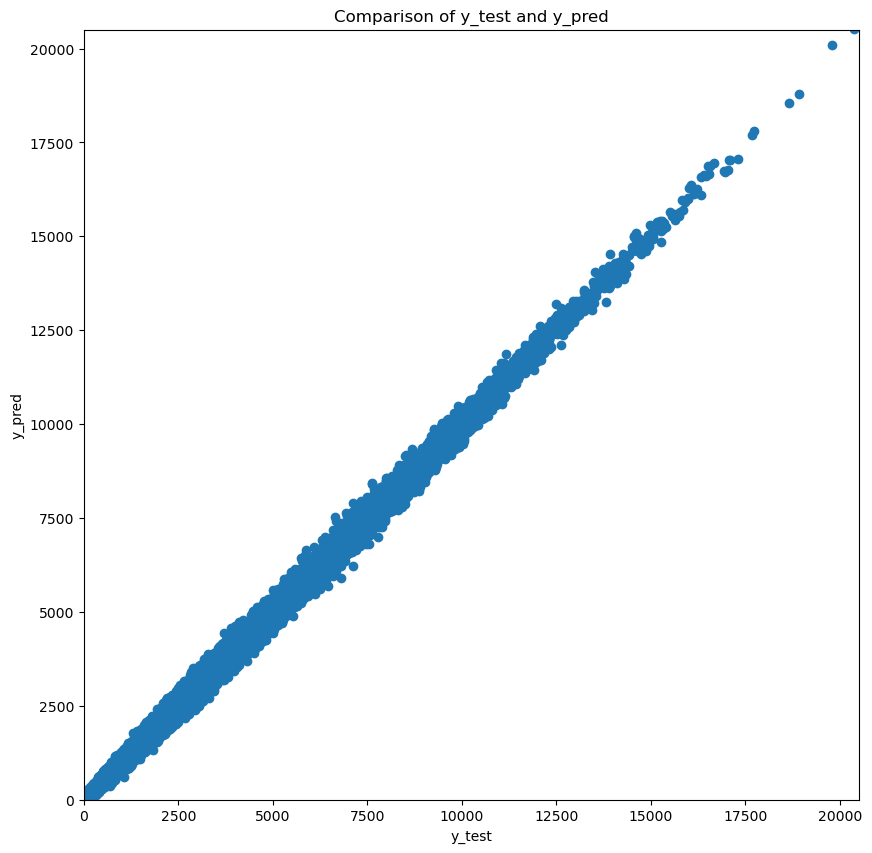

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

### 3. Comparison with `extrucal` results

In [13]:
extruder_size = []
for i in range(50, 251, 50):
    extruder_size.extend([i]*10)

metering_depth_percent = [0.05] * 50
polymer_density = [1000] * 50
screw_pitch_percent = [1] * 50
flight_width_percent = [0.1] * 50
number_flight = [1] * 50
rpm = [r for r in range(0, 91, 10)] * 5

In [14]:
df = pd.DataFrame(
    {"extruder_size": extruder_size,
     "metering_depth_percent": metering_depth_percent,
     "polymer_density": polymer_density,
     "screw_pitch_percent": screw_pitch_percent,
     "flight_width_percent": flight_width_percent,
     "number_flight": number_flight,
     "rpm": rpm}
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size", "metering_depth", "polymer_density", 
    "rpm", "screw_pitch", "flight_width", "number_flight", ]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,50,2.5,1000,0,50,5.0,1
1,50,2.5,1000,10,50,5.0,1
2,50,2.5,1000,20,50,5.0,1
3,50,2.5,1000,30,50,5.0,1
4,50,2.5,1000,40,50,5.0,1


In [15]:
df["XGBoost_model"] = pipe_xgb.predict(df)

In [16]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"])), axis=1
)

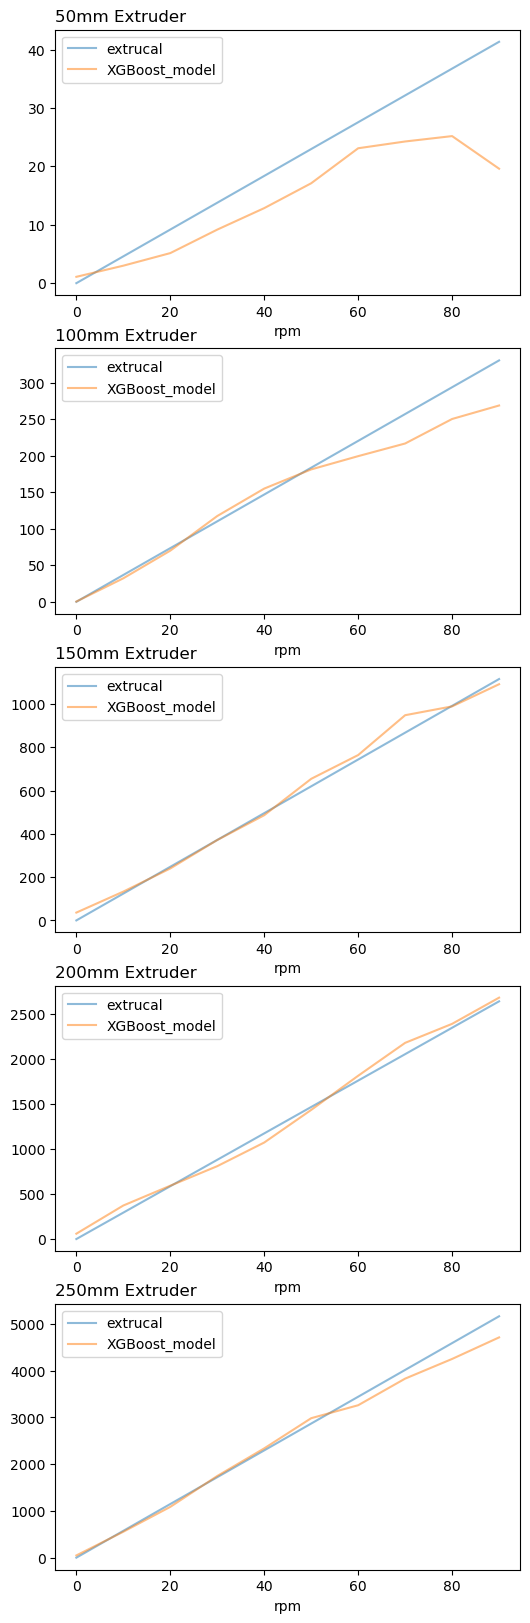

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))

fig = df.loc[0:9, ["rpm", "extrucal", "XGBoost_model"]].plot.line(
    x="rpm", ax=axes[0], alpha=0.5
)
fig.set_title("50mm Extruder", loc='left')
fig = df.loc[10:19, ["rpm", "extrucal", "XGBoost_model"]].plot.line(
    x="rpm", ax=axes[1], alpha=0.5
)
fig.set_title("100mm Extruder", loc='left')
fig = df.loc[20:29, ["rpm", "extrucal", "XGBoost_model"]].plot.line(
    x="rpm", ax=axes[2], alpha=0.5
)
fig.set_title("150mm Extruder", loc='left')
fig = df.loc[30:39, ["rpm", "extrucal", "XGBoost_model"]].plot.line(
    x="rpm", ax=axes[3], alpha=0.5
)
fig.set_title("200mm Extruder", loc='left')
fig = df.loc[40:, ["rpm", "extrucal", "XGBoost_model"]].plot.line(
    x="rpm", ax=axes[4], alpha=0.5
)
fig.set_title("250mm Extruder", loc='left')
plt.show();